Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [12]:
%load_ext watermark
%watermark -v -m -p pandas,matplotlib,seaborn,scikit-learn,tensorflow,keras,os,augmentor,shutil

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.21.0

pandas      : 2.2.0
matplotlib  : 3.8.3
seaborn     : 0.13.2
scikit-learn: 1.4.1.post1
tensorflow  : 2.16.1
keras       : 3.0.5
os          : unknown
augmentor   : not installed
shutil      : unknown

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [21]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, AdamW, Adadelta, Adagrad, Adamax, Nadam, Ftrl

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
# Count the number of images in the training data directory
# This is done by listing all files with .jpg extension in all subdirectories
# of the training data directory and getting the length of the list
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
# Print the number of images in the training data directory
print(image_count_train)

# Count the number of images in the testing data directory
# This is done by listing all files with .jpg extension in all subdirectories
# of the testing data directory and getting the length of the list
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
# Print the number of images in the testing data directory
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names # correspond to the directory names in alphabetical order.
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2024-03-20 15:36:30.585284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


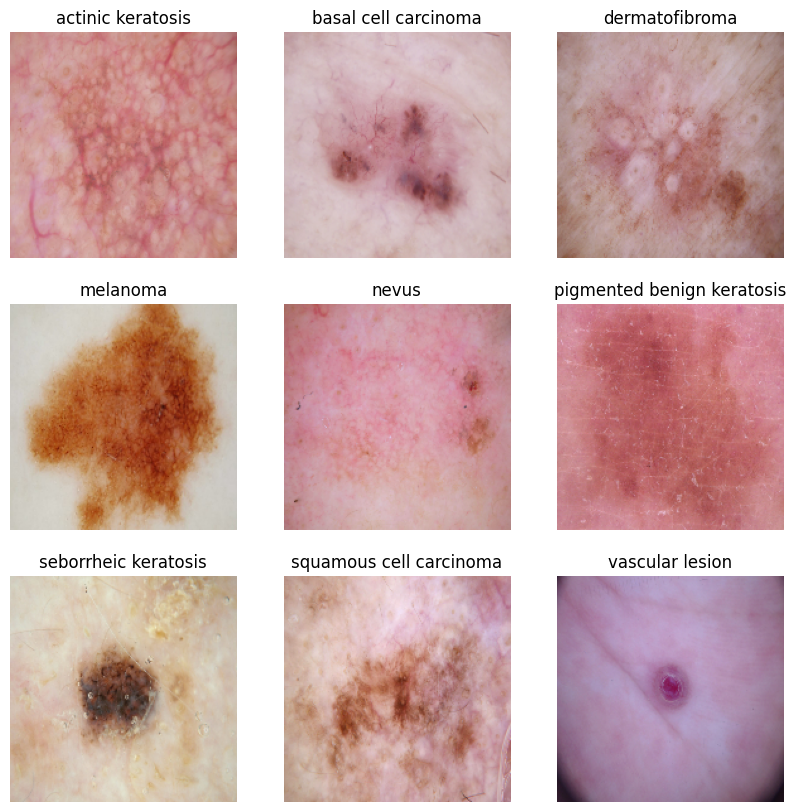

In [9]:
# Create a dictionary to store one image per class
images_per_class = {}

# Iterate over the train dataset and store the first image of each class
for image, label in train_ds:
    for im, l in zip(image, label):
        images_per_class.setdefault(l.numpy(), im) # setdefault() sets a value for a key in the dictionary only if the key is not already in the dictionary.
        if len(images_per_class) == 10:
            break
    if len(images_per_class) == 10:
        break

# for images, labels in train_ds.take(1): # Take one batch from the training dataset

plt.figure(figsize=(10, 10)) # Set the figure size

for label, image in images_per_class.items():
  ax = plt.subplot(3, 3, label + 1) # Create a subplot for each image
  plt.imshow(image.numpy().astype("uint8")) # Display the image
  plt.title(class_names[label]) # Set the title of the plot to the corresponding class name
  plt.axis("off") # Turn off the axis

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
# Set AUTOTUNE to tf.data.experimental.AUTOTUNE to dynamically adjust the prefetch buffer size based on the system environment.
# represents the best possible performance for data prefetching.
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Cache the train dataset in memory, shuffle the data randomly and prefetch elements from the dataset for faster data retrieval.
# Shuffling with a buffer of 1000 ensures that the data is well mixed.
# The argument 1000 represents the buffer size for shuffling, which determines how many elements are shuffled at a time.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache the validation dataset in memory and prefetch elements from the dataset for faster data retrieval.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
# Importing required layers from tensorflow.keras to build model
from keras.layers import Conv2D     # Convolutional 2D Layer for image processing
from keras.layers import MaxPooling2D  # MaxPooling 2D Layer for downsampling input
from keras.layers import Flatten    # Flatten Layer for transforming input to 1D array
from keras.layers import Dense      # Dense Layer for output and hidden layers


In [11]:
# initialize create_vgg16_model function
def create_vgg16_model():

    # Clear the Keras session
    tf.keras.backend.clear_session()
    
    # Create a Sequential model
    model = Sequential([

        # The RGB channel values are in the [0, 255] range, and this is not ideal for a neural network.
        # By dividing pixel values by 255, we can standardize them to be in the [0, 1] range.
        # Normalize pixel values between 0 and 1
        layers.Rescaling(1./255),

        # conv block 1
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # conv block 2
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # conv block 3
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # conv block 4
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # conv block 5
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        ## Classification block

        # flatten layer
        Flatten(),

        # Fully Connected Layers
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(9, activation='softmax')
    ])

    return model



In [ ]:

# create the model
model = create_vgg16_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# build the model
model.build(input_shape=(None, img_height, img_width, 3))

# model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    52,432,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │        36,873 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,965,769 (320.30 MB)

 Trainable params: 83,965,769 (320.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20


I0000 00:00:1710475533.680650   34306 service.cc:145] XLA service 0x703b20019160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1710475533.680706   34306 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-15 04:05:33.817798: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-15 04:05:34.487479: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1710475562.967205   34306 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 500ms/step - accuracy: 0.2290 - loss: 2.8930 - val_accuracy: 0.2058 - val_loss: 2.0529
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.2073 - loss: 2.0014 - val_accuracy: 0.1924 - val_loss: 2.0333
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.1928 - loss: 2.0058 - val_accuracy: 0.2058 - val_loss: 2.0350
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.2032 - loss: 2.0242 - val_accuracy: 0.2058 - val_loss: 2.0227
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.1996 - loss: 1.9949 - val_accuracy: 0.2058 - val_loss: 2.0245
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step - accuracy: 0.1744 - loss: 2.0413 - val_accuracy: 0.2058 - val_loss: 2.0262
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 300ms/step - accuracy: 0.1953 - loss: 2.0369 - val_accuracy: 0.2058 - val_loss: 2.0254
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 298ms/step - accuracy: 0.2025 - loss: 2.0471 - val_accuracy: 0.205

In [12]:
## simplifiy the model

# initialize create_simplified_vgg16_model function
def create_simplified_vgg16_model():
    
    # Clear the Keras session
    tf.keras.backend.clear_session()

    # Create a Sequential model
    model = Sequential([

        # Normalize pixel values between 0 and 1
        layers.Rescaling(1./255),

        # Convolutional block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Convolutional block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Convolutional block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Flatten layer
        Flatten(),

        # Fully connected layers
        Dense(128, activation='relu'),
        Dense(9, activation='softmax')
    ])

    return model


In [ ]:

# create the model
model = create_simplified_vgg16_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# build the model
model.build(input_shape=(None, img_height, img_width, 3))

# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.1703 - loss: 2.2643 - val_accuracy: 0.1588 - val_loss: 2.0436
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2752 - loss: 1.9236 - val_accuracy: 0.4206 - val_loss: 1.6424
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4222 - loss: 1.5818 - val_accuracy: 0.5190 - val_loss: 1.3844
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5131 - loss: 1.3790 - val_accuracy: 0.5324 - val_loss: 1.4008
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5328 - loss: 1.3131 - val_accuracy: 0.4855 - val_loss: 1.4813
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5440 - loss: 1.2736 - val_accuracy: 0.5347 - val_loss: 1.4160
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5772 - loss: 1.2190 - val_accuracy: 0.5436 - val_loss: 1.3403
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6189 - loss: 1.0695 - val_accuracy: 0.5526 - v

In [ ]:
# install required packages to visualize the model
!pip install pydot
!sudo apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-7build3).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


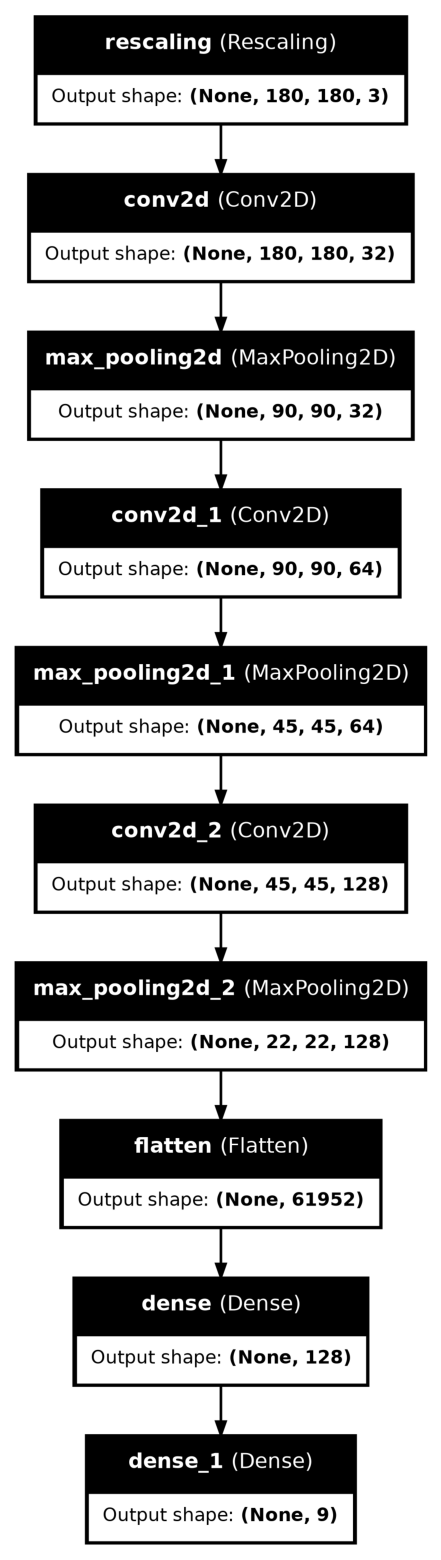

In [ ]:
## visualize the model

# import required libraries
from keras.utils import plot_model

# plot the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

plt.figure(figsize=(20, 20)) # Set the figure size

# Display the image
plt.imshow(plt.imread('model.png'))
plt.axis('off')
plt.show()



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
# Function to compile and train the model with different optimizers
def try_all_optimizers(epochs=10):

    # List of optimizers to be used
    optimizers = [SGD, RMSprop, Adam, AdamW, Adadelta, Adagrad, Adamax, Nadam, Ftrl]
    
    # Loop through each optimizer
    for opt in optimizers:
        
      # Create a new model
        model = create_simplified_vgg16_model()
        
        # Compile the model with the current optimizer and sparse categorical crossentropy loss
        model.compile(optimizer=opt(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Print the optimizer being used
        print(f'Training with {opt.__name__} optimizer')
        
        # Train the model with the training dataset and validation dataset
        history = model.fit( train_ds, validation_data=val_ds, epochs=epochs)
        
        # Print the final loss and accuracy of the model after training
        print(f'{opt.__name__} Training Loss: {history.history["loss"][-1]}')
        print(f'{opt.__name__} Training Accuracy: {history.history["accuracy"][-1]}')
        
        # Print a separator
        print('-----------------------------------')

# execute the function
try_all_optimizers()

Training with SGD optimizer
Epoch 1/10


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1647 - loss: 2.0529 - val_accuracy: 0.2595 - val_loss: 2.0233
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2277 - loss: 2.0093 - val_accuracy: 0.1946 - val_loss: 2.0120
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2250 - loss: 2.0109 - val_accuracy: 0.3199 - val_loss: 1.9889
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2631 - loss: 1.9819 - val_accuracy: 0.2506 - val_loss: 1.9792
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2662 - loss: 1.9490 - val_accuracy: 0.2752 - val_loss: 1.9284
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2681 - loss: 1.9375 - val_accuracy: 0.3177 - val_loss: 1.8713
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3029 - loss: 1.9124 - val_accuracy: 0.3557 - val_loss: 1.8442
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3049 - loss: 1.8622 - val_accuracy: 0.3870 - val_loss: 1.

- After running the test, it was found that the Adam, AdamW, and Nadam optimizers achieved the highest accuracy among all the optimizers tested.

- The next step is to further evaluate the performance of these three optimizers by running additional tests and comparisons.


In [ ]:
# Function to compile and train the model with different optimizers
def try_selected_optimizers(epochs=20):

    # List of selected optimizers
    selected_optimizers = [Adam, AdamW, Nadam]
    
    # Loop through each optimizer
    for opt in selected_optimizers:
        
      # Create a simplified VGG16 model
        model = create_simplified_vgg16_model()
        
        # Compile the model with the current optimizer and sparse categorical crossentropy loss
        model.compile(optimizer=opt(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Print the optimizer being used for training
        print(f'Training with {opt.__name__} optimizer')
        
        # Train the model with the training dataset and validation dataset
        history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
        
        # Print the final training loss and accuracy for the current optimizer
        print(f'{opt.__name__} Training Loss: {history.history["loss"][-1]}')
        print(f'{opt.__name__} Training Accuracy: {history.history["accuracy"][-1]}')
        
        # Print a separator
        print('-----------------------------------')

# Execute the function
try_selected_optimizers()


Training with Adam optimizer
Epoch 1/20


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.1980 - loss: 2.3566 - val_accuracy: 0.3020 - val_loss: 1.8952
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3172 - loss: 1.8289 - val_accuracy: 0.4027 - val_loss: 1.6965
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4550 - loss: 1.5268 - val_accuracy: 0.4899 - val_loss: 1.4809
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5094 - loss: 1.4169 - val_accuracy: 0.5168 - val_loss: 1.4674
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5015 - loss: 1.4106 - val_accuracy: 0.5123 - val_loss: 1.4768
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5542 - loss: 1.2403 - val_accuracy: 0.5213 - val_loss: 1.5193
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5830 - loss: 1.1380 - val_accuracy: 0.4989 - val_loss: 1.6549
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5663 - loss: 1.2193 - val_accuracy: 0.5034 - val_loss: 1.

In [ ]:
# ### Todo, choose an appropirate optimiser and loss function
# create the model
model = create_simplified_vgg16_model()

# select Adam as apropriate
model.compile(optimizer='adam',
              # This loss function is used because the labels are integers.
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.build(input_shape=(None, img_height, img_width, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2145 - loss: 2.6901 - val_accuracy: 0.3647 - val_loss: 1.8261
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3191 - loss: 1.8370 - val_accuracy: 0.5011 - val_loss: 1.4746
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4805 - loss: 1.4599 - val_accuracy: 0.4855 - val_loss: 1.5176
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5384 - loss: 1.3128 - val_accuracy: 0.4720 - val_loss: 1.6012
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5590 - loss: 1.2561 - val_accuracy: 0.5347 - val_loss: 1.4325
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5861 - loss: 1.1824 - val_accuracy: 0.5056 - val_loss: 1.4417
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6076 - loss: 1.0765 - val_accuracy: 0.5414 - val_loss: 1.4310
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6116 - loss: 1.0493 - val_accuracy: 0.5660 - v

### Visualizing training results

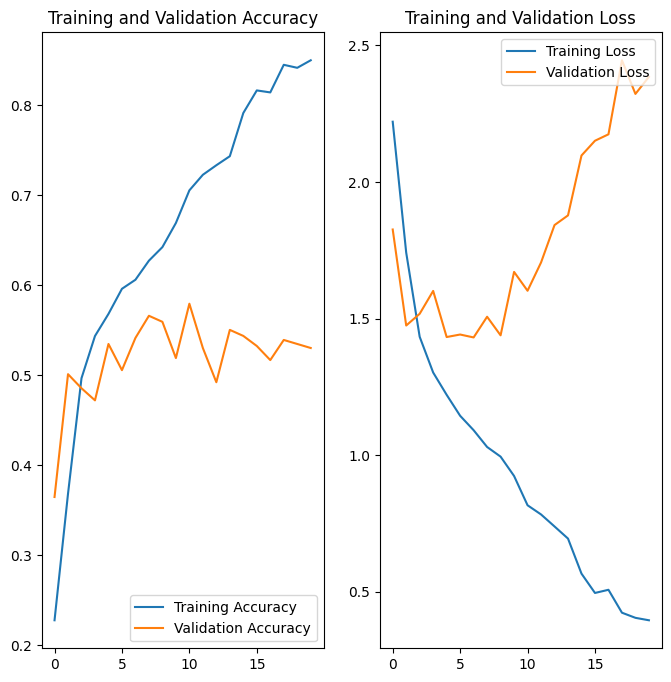

In [ ]:
# Extracting accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Creating a range of epochs
epochs_range = range(epochs)

# Setting up the figure size
plt.figure(figsize=(8, 8))

# Creating the first subplot for accuracy
plt.subplot(1, 2, 1)

# Plotting the training and validation accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Adding a legend to the plot
plt.legend(loc='lower right')

# Adding a title to the plot
plt.title('Training and Validation Accuracy')

# Creating the second subplot for loss
plt.subplot(1, 2, 2)

# Plotting the training and validation loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Adding a legend to the plot
plt.legend(loc='upper right')

# Adding a title to the plot
plt.title('Training and Validation Loss')

# Displaying the plot
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- The model accuracy on training data show promising improvment over the course of 20 epochs.
- There are indications of overfitting because validation accuracy is declining while training accuracy continue to rise.
- Apply data augmentation techniques to overcome overfitting.

### Write your findings here

In [13]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

# ideas gotten from https://www.youtube.com/watch?v=o1zcWYrulEQ
# Define data augmentation layers
data_augmentation = keras.Sequential([

    # randomly flip images on both axes
    layers.RandomFlip("horizontal_and_vertical"),

    # Randomly rotate images 
    layers.RandomRotation(1),

    # Randomly adjust the brightness of images
    layers.RandomBrightness(0.2),

    # Randomly adjust the contrast of images
    layers.RandomContrast(0.2),
])



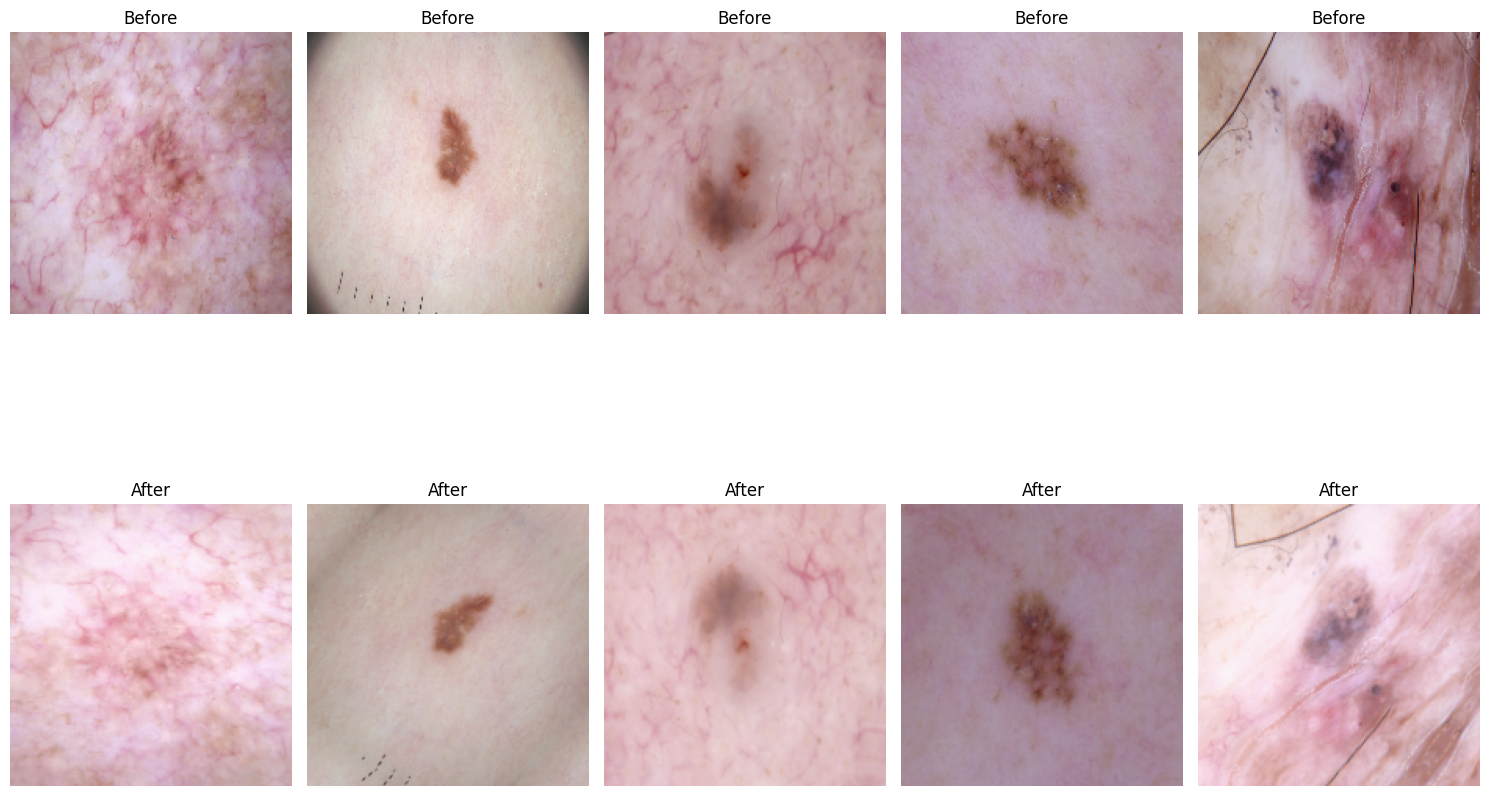

In [15]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Take one batch of images and labels from the training dataset
images, labels = next(iter(train_ds))

# Apply the data_augmentation layers to the batch of images
augmented_images = data_augmentation(images)

# Plot the original and augmented images
plt.figure(figsize=(15, 15))

# Creating a grid of subplots to display images.
for i in range(5):
    
  # This subplot is for the original image.

    # Creates a subplot grid of 3 rows and 5 columns
    plt.subplot(3, 5, i + 1)
    # Displays an image in the current subplot.
    plt.imshow(images[i].numpy().astype("uint8"))
    # Turns off the axis lines and labels for the current subplot
    plt.axis("off")
    # Sets the title of the current subplot to 'Before'
    plt.title('Before')

    # This subplot is for the augmented image.
    
    # Creates a subplot grid of 3 rows and 5 columns
    plt.subplot(3, 5, i + 6)
    # Displays an image in the current subplot.
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    # Turns off the axis lines and labels for the current subplot
    plt.axis("off")
    # Sets the title of the current subplot to 'Before'
    plt.title('After')

# Adjust the layout of the subplots.
plt.tight_layout()

### Todo:
### Create the model, compile and train the model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 180, 180, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

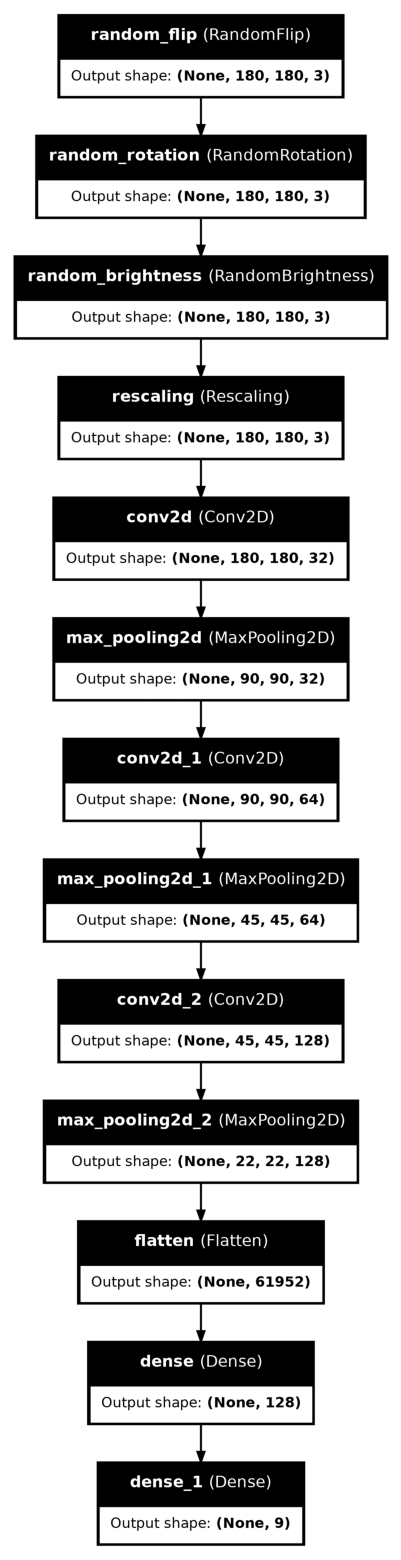

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Create a simplified version of the VGG16 model
old_model = create_simplified_vgg16_model()

# initialize new model
model = Sequential()

# Add the data augmentation layers to the new model
[model.add(layer) for layer in data_augmentation.layers]

# Add the old model layers to the new model
[model.add(layer) for layer in old_model.layers]

# build the model
model.build(input_shape=(None, img_height, img_width, 3))

# model summary
model.summary()

# plot the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

plt.figure(figsize=(20, 20)) # Set the figure size

# Display the image
plt.imshow(plt.imread('model.png'))
plt.axis('off')
plt.show()

### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.1832 - loss: 2.1910 - val_accuracy: 0.3870 - val_loss: 1.7749
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3602 - loss: 1.7549 - val_accuracy: 0.4116 - val_loss: 1.6685
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4134 - loss: 1.5883 - val_accuracy: 0.5257 - val_loss: 1.4371
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4731 - loss: 1.4627 - val_accuracy: 0.4586 - val_loss: 1.5345
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4677 - loss: 1.4500 - val_accuracy: 0.4966 - val_loss: 1.4067
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4659 - loss: 1.4593 - val_accuracy: 0.5235 - val_loss: 1.3921
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4954 - loss: 1.3956 - val_accuracy: 0.5034 - val_loss: 1.4054
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5037 - loss: 1.3511 - val_accuracy: 0.5324 - v

### Visualizing the results

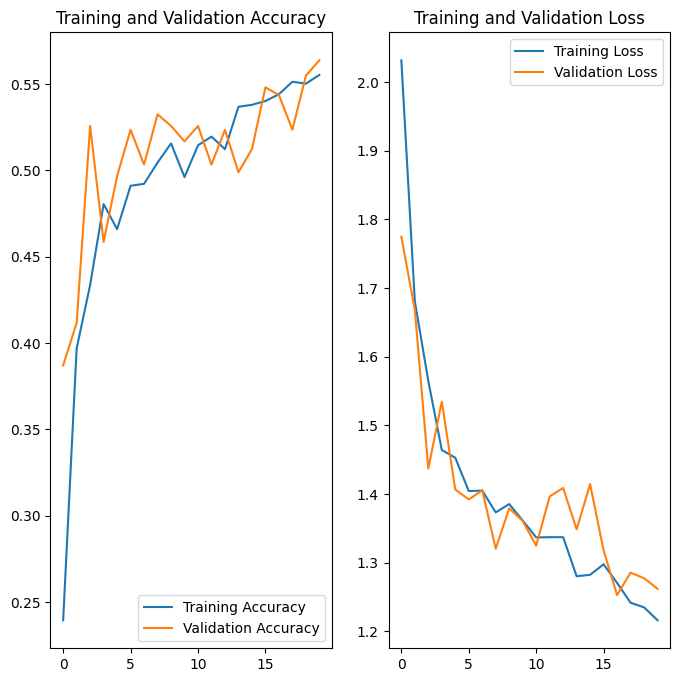

In [ ]:
# Extracting accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Creating a range of epochs
epochs_range = range(epochs)

# Setting up the figure size
plt.figure(figsize=(8, 8))

# Creating the first subplot for accuracy
plt.subplot(1, 2, 1)
# Plotting the training and validation accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Adding a legend to the plot
plt.legend(loc='lower right')

# Adding a title to the plot
plt.title('Training and Validation Accuracy')

# Creating the second subplot for loss
plt.subplot(1, 2, 2)

# Plotting the training and validation loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Adding a legend to the plot
plt.legend(loc='upper right')

# Adding a title to the plot
plt.title('Training and Validation Loss')

# Displaying the plot
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- __Model Underfit__: The training loss does not decrease significantly.
- __Improvement__: Compared to the previous model run, the model overfiting issue has been handled profoundly. However, the model still seems to be underfitting, and there is room for improvement.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

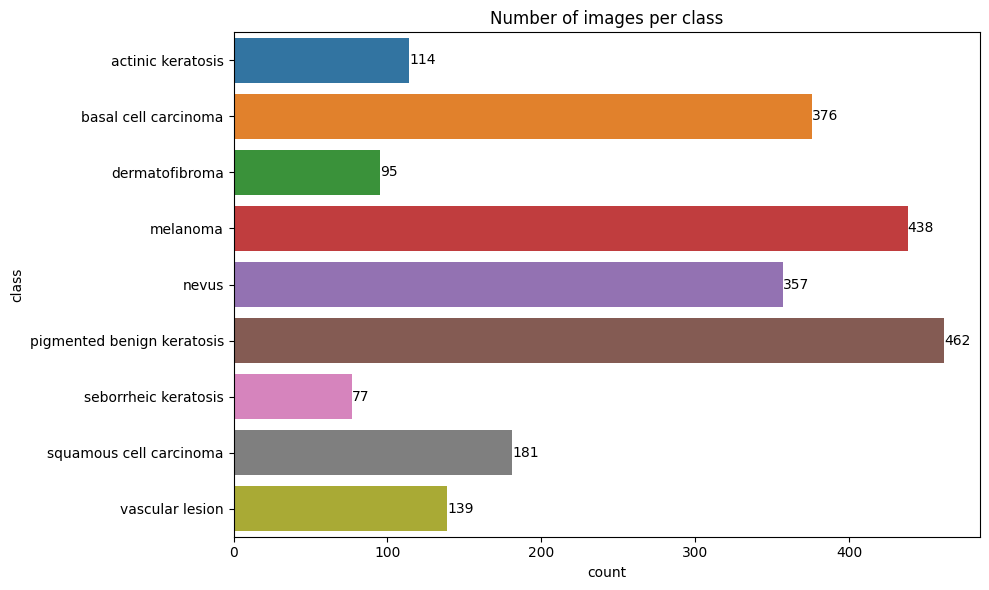

In [ ]:
## Your code goes here.
# initialize the count of images in each class
counts = []
# Loop through each class name in the list of class names
for c in class_names:
  # For each class, count the number of .jpg files in the training data directory
    counts.append(len(list(data_dir_train.glob(str(c) + '/*.jpg'))))

# Create a DataFrame with the counts
class_dist = pd.DataFrame({'class': class_names, 'count': counts})

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=class_dist, y='class', x='count', hue='class', legend=False)
plt.title('Number of images per class')

# Add bar labels
[ax.bar_label(container) for container in ax.containers] 

# Adjust the layout of the plot to fit the figure area.
plt.tight_layout()

# Display the plot
plt.show()



#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


- __Least Samples__: The class with the least number of samples is seborrheic keratosis.
- __Most Samples__: The classes that dominate the data with the most samples are melanoma and pigmented benign keratosis.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [15]:
# Importing the Augmentor package for data augmentation
import Augmentor
   
# Define the new directory
data_dir_train_aug = pathlib.Path("./Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmentor")

# Create the new directory
data_dir_train_aug.mkdir(parents=True, exist_ok=True)


In [17]:
##  unbatch train_ds and save the images to the new directory. 

# Unbatch the dataset
train_ds_unbatched = train_ds.unbatch()

# Initialize a counter
i = 0

# Iterate over the train_ds and copy the images to the new directory
for image, label in train_ds_unbatched:
    class_name = class_names[label.numpy()]
    new_class_dir = data_dir_train_aug / class_name
    new_class_dir.mkdir(parents=True, exist_ok=True)
    filename = f"image_{i}.jpg"
    tf.keras.preprocessing.image.save_img(new_class_dir / filename, image)
    i += 1

2024-03-20 13:20:51.495683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# Print the number of images in the Train_augmentor directory
image_count_train_aug = len(list(data_dir_train_aug.glob('*/*.jpg')))
print(image_count_train_aug)

1792


In [ ]:
# initialize the count of images in each class
counts = []

# Loop through each class name
for c in class_names:

    # Count the total number of images in the class directory
    counts.append(len(list(data_dir_train_aug.glob(str(c) + '/*.jpg'))))

# Augment training data
augmentors = []

# Loop through each class name
for c in class_names:

    # Create Augmentor pipeline for class
    p = Augmentor.Pipeline(data_dir_train_aug / c) 

    ## Add data augmentation operations
    # Rotate images randomly between -10 and 10 degrees
    p.rotate(probability=1, max_left_rotation=10, max_right_rotation=10)
    
    # Rotate the image p randomly by 90 degrees with a probability of 1
    p.rotate_random_90(probability=1)

    # Flip images randomly both axes with probability of 1
    p.flip_random(probability=1) 

    # Add the random_distortion operation to the pipeline
    p.random_distortion(probability=1, grid_width=8, grid_height=8, magnitude=8)

    # Apply skew transformation 
    p.skew(probability=1, magnitude=0.3)

    # Add pipeline to list
    augmentors.append(p)



# Define the target total number of images in each class
target_count = 500

# Iterate over the augmentors list with their indices
for i, p in enumerate(augmentors):
  # If the difference between the target count and the current count is 0, skip the current iteration
    if (target_count - counts[i]) == 0: continue
    # If the difference is not 0, sample from the current augmentor to reach the target count
    p.sample(target_count - counts[i])

2024-03-18 06:08:26.890406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1792
Initialised with 92 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmentor/actinic keratosis/output.Initialised with 309 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmentor/basal cell carcinoma/output.Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmentor/dermatofibroma/output.Initialised with 352 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmentor/melanoma/output.Initialised with 277 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmentor/nevus/output.Initialised with 370 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmentor/pigmented benign keratosis/output.Initialised with 58 image

Processing <PIL.Image.Image image mode=RGB size=600x600 at 0x7B57B0304F90>: 100%|██████████| 408/408 [00:05<00:00, 71.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x600 at 0x7B57CB307C90>: 100%|██████████| 191/191 [00:02<00:00, 74.52 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x600 at 0x7B57B0689010>: 100%|██████████| 423/423 [00:05<00:00, 74.98 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x600 at 0x7B57CACFD390>: 100%|██████████| 148/148 [00:02<00:00, 73.21 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x600 at 0x7B57CBE106D0>: 100%|██████████| 223/223 [00:03<00:00, 72.59 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x600 at 0x7B57C81D1AD0>: 100%|██████████| 130/130 [00:01<00:00, 73.72 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x600 at 0x7B57B0363C90>: 100%|██████████| 442/442 [00:06<00:00, 72.41 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x600 at 0x7B57B0685510>: 

2708


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [19]:
image_count_train = len(list(data_dir_train_aug.glob('*/output/*.jpg')))
print(image_count_train)

2708


### Lets see the distribution of augmented data after adding new images to the original training data.

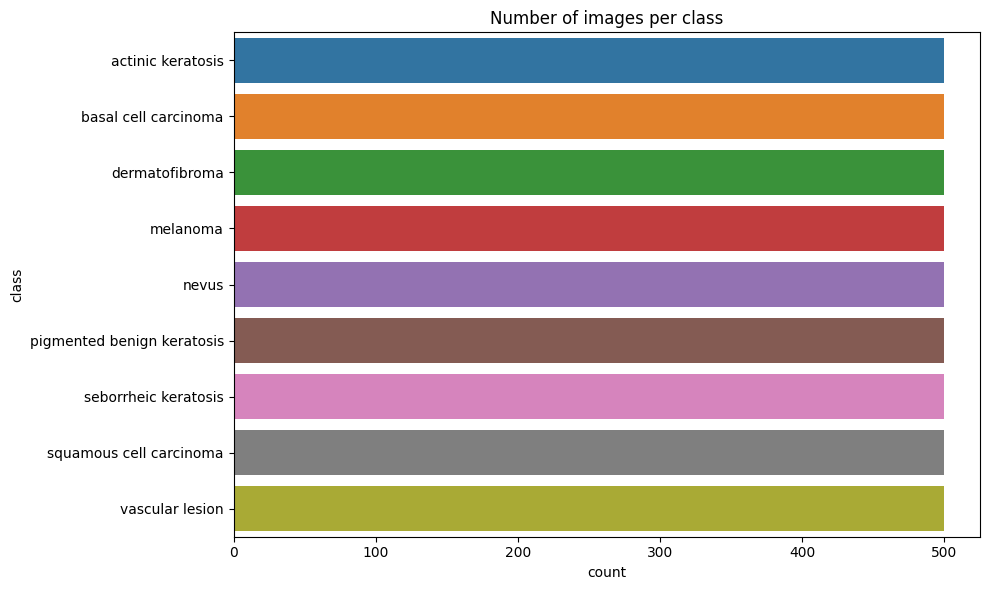

In [20]:
# initialize the count of images in each class
counts = []

# Loop through each class name
for c in class_names:

    # Count the total number of images in the class directory
    num_images = len(list(data_dir_train_aug.glob(str(c) + '/*.jpg')))
    
    # Count the number of images in the output folder in the class directory
    output_images = len(list(data_dir_train_aug.glob(str(c) + '/output/*.jpg')))

    # Add the counts to the list
    counts.append(num_images + output_images)

    # Create a DataFrame with the counts
train_ds_dist = pd.DataFrame({'class': class_names, 'count': counts})

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=train_ds_dist, y='class', x='count', hue='class', legend=False)
plt.title('Number of images per class')

# Adjust the layout of the plot to fit the figure area.
plt.tight_layout()
# Display the plot
plt.show()

So, now we have added images so that each class would have a total of 500 images to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [21]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [22]:
## Move and rename images from output to parents
# Importing the shutil module
import shutil

# Loop through each class name
for c in class_names:
  # Define the output directory
    output_dir = data_dir_train_aug / c / 'output'
    # Loop through each file in the output directory
    for filename in os.listdir(output_dir):
        # Remove the original class name from the filename
        new_filename = filename.replace(f"{c}_original_", '')
        # Rename the file
        os.rename(os.path.join(output_dir, filename), os.path.join(output_dir, new_filename))
        # Move the renamed file to the class directory
        shutil.move(os.path.join(output_dir, new_filename), os.path.join(data_dir_train_aug, c))

    # Delete the empty output folder
    shutil.rmtree(output_dir)


In [15]:
# Define the new train_ds dataset
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train_aug,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Found 4500 files belonging to 9 classes.


#### **Todo:** Create a validation dataset

Use previous validation set to avoid overlapping with its elements' augmented samples

In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Using 447 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [17]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, Add, MaxPooling2D, Dense, BatchNormalization, Activation, Dropout
from keras.initializers import HeNormal
from keras.regularizers import l2

# Define function that create residual blocks
def residual_block(layer, filters_num, kernel_size=3, stride=1):
    
  # Shortcut connection
  prev = Conv2D(filters_num, kernel_size=1, strides=stride, padding='same')(layer)

  # First convolutional layer
  layer = Conv2D(filters_num, kernel_size=kernel_size, strides=stride, padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(layer)
  layer = BatchNormalization() (layer)
  layer = Activation('relu') (layer)
  # Adding the shortcut to the output of the first convolutional layer
  layer = Add()([layer, prev])

  # Max pooling layer
  layer = MaxPooling2D(pool_size=(2, 2)) (layer)
  # Updating the shortcut
  prev = layer

  # Second convolutional layer
  layer = Conv2D(filters_num, kernel_size=kernel_size, strides=stride, padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(layer)
  layer = BatchNormalization() (layer)
  # Merging the second convolutional layer with the shortcut
  layer = Add()([layer, prev])
  # Applying the ReLU activation function
  layer = Activation('relu') (layer)

  return layer


In [18]:
# Clear the Keras session
tf.keras.backend.clear_session()

# Define the input layer
input = Input(shape=(180, 180, 3), name='Input_Layer')

# Randomly flip images both axes    
layer = layers.RandomFlip("horizontal_and_vertical") (input)
# Randomly rotate images by a fraction of 2
layer = layers.RandomRotation(1) (layer)
# Randomly adjust the brightness of images
layer = layers.RandomBrightness(0.2) (layer)
# Randomly adjust the contrast of images
layer = layers.RandomContrast(0.2) (layer)
# Normalize pixel values between 0 and 1
layer = layers.Rescaling(1./255) (layer)

# Convolutional block 1
layer = Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)) (layer)
# Batch normalization layer
layer = BatchNormalization() (layer)
# ReLU activation layer
layer = Activation('relu') (layer)
# Convolutional block 1
layer = Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)) (layer)
# Batch normalization layer
layer = BatchNormalization() (layer)
# ReLU activation layer
layer = Activation('relu') (layer)
layer = MaxPooling2D(pool_size=(2, 2)) (layer)

# Convolutional block 2
layer = residual_block(layer, 128)
layer = MaxPooling2D(pool_size=(2, 2)) (layer)

# Convolutional block 3
layer = residual_block(layer, 256)
layer = MaxPooling2D(pool_size=(2, 2)) (layer)

# Flatten layer
layer = Flatten() (layer)
# layer = GlobalAveragePooling2D() (layer)

# Fully connected layers 1
layer = Dense(1024, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)) (layer)
# Batch normalization layer
layer = BatchNormalization() (layer)
# ReLU activation layer
layer = Activation('relu') (layer)
layer = Dropout(0.5) (layer)  # Apply dropout with a rate of 0.5


# Fully connected layers 2
layer = Dense(1024, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)) (layer)
# Batch normalization layer
layer = BatchNormalization() (layer)
# ReLU activation layer
layer = Activation('relu') (layer)
layer = Dropout(0.5) (layer)  # Apply dropout with a rate of 0.5

#output layer
output = Dense(9, activation='softmax', kernel_regularizer=l2(0.01)) (layer)
model = Model(inputs=input, outputs=output)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 180, 180,  │          0 │ Input_Layer[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 180, 180,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_brightness   │ (None, 180, 180,  │          0 │ random_rotation[… │
│ (RandomBrightness)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 180, 180,  │          0 │ random_brightnes… │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ random_contrast[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 180, 180,  │      1,792 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 180, 180,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 180, 180,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 180, 180,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 180,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 180, 180,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 90, 90,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 90, 90,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 90, 90,    │      8,320 │ max_pooling2d[0]

 Total params: 8,811,977 (33.62 MB)

 Trainable params: 8,806,089 (33.59 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [19]:
# # Learning Rate Reduction setup
# # code from here https://stackoverflow.com/questions/66530274/tricks-to-improve-cnn-model-performance
# Import ReduceLROnPlateau from keras.callbacks module
from keras.callbacks import ReduceLROnPlateau

# Create a ReduceLROnPlateau object
reduce_lr = ReduceLROnPlateau(
  # Monitor the validation loss
    monitor='val_loss', 
    # Reduce the learning rate by a factor of 0.9
    factor=0.9, 
    # Wait for 1 epoch without improvement before reducing the learning rate
    patience=1, 
    # Set the minimum learning rate to 0.000001
    min_lr=0.000001
)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [22]:
## your code goes here
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [23]:
epochs = 30
## Your code goes here, use 50 epochs.
# Train the model using the fit() method
history = model.fit(
    train_ds_aug, 
    validation_data=val_ds,
    epochs=50, 
    callbacks=[reduce_lr],  # Pass a list of callbacks, including the learning rate reduction callback
    shuffle=True  # Shuffle the training data before each epoch
)


Epoch 1/50


2024-03-20 14:24:21.613532: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


141/141 ━━━━━━━━━━━━━━━━━━━━ 58s 314ms/step - accuracy: 0.2428 - loss: 59.9453 - val_accuracy: 0.1655 - val_loss: 55.4484 - learning_rate: 1.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 0.3550 - loss: 53.5214 - val_accuracy: 0.3378 - val_loss: 49.1175 - learning_rate: 1.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 296ms/step - accuracy: 0.3888 - loss: 47.6482 - val_accuracy: 0.4519 - val_loss: 43.4487 - learning_rate: 1.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 296ms/step - accuracy: 0.4108 - loss: 42.2588 - val_accuracy: 0.5213 - val_loss: 38.4565 - learning_rate: 1.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 297ms/step - accuracy: 0.4492 - loss: 37.4182 - val_accuracy: 0.5213 - val_loss: 33.9894 - learning_rate: 1.0000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 297ms/step - accuracy: 0.4591 - loss: 33.1241 - val_accuracy: 0.3915 - val_loss: 30.2713 - learning_rate: 1.0000e-04
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 2

#### **Todo:**  Visualize the model results

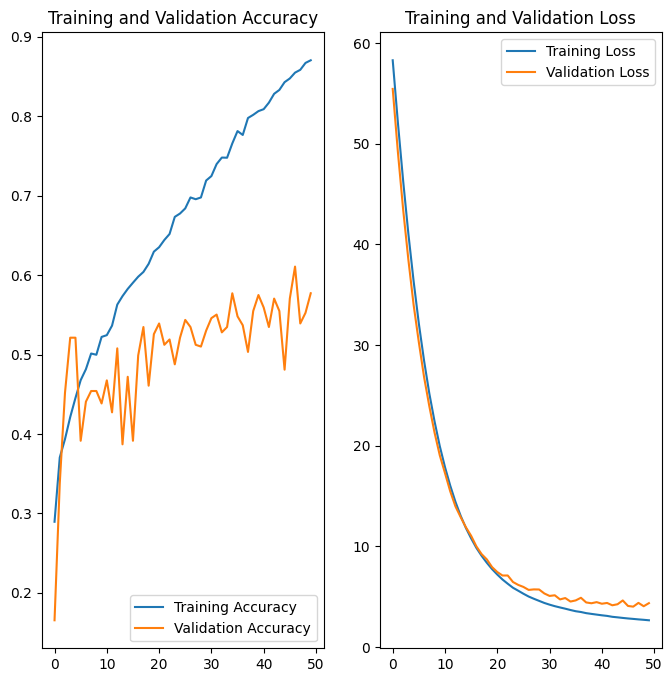

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- Overfitting persists despite the use of various approaches such as regularization, dropout, batch normalization, etc.
- As a side note, the loss indication clearly shows a decline over the course of the epochs.
- Class rebalancing appears to have a partial effect, but the accuracy remains below 60%, indicating continuing underperformance.

### Other models experiments

#### ResNet with weights

In [ ]:
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D

# Clear the Keras session
tf.keras.backend.clear_session()

# Load ResNet with random weights and without the top fully-connected layers
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Add new layers on top of ResNet
# Fully connected layers 2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# # Apply dropout with a rate of 0.5
# x = Dropout(0.5) (x) 

predictions = Dense(9, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the new data
model.fit(train_ds_aug, validation_data=val_ds, epochs=20, callbacks=[reduce_lr], shuffle=True)


Epoch 1/20


I0000 00:00:1710758009.005898   15460 service.cc:145] XLA service 0x1034d9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1710758009.005945   15460 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-18 10:33:30.056639: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-18 10:33:38.835710: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-18 10:33:38.835777: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.25GiB with freed_by_count=0. The caller indicates that this is not a failur

 60/141 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - accuracy: 0.4490 - loss: 1.5790

2024-03-18 10:34:18.843283: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


141/141 ━━━━━━━━━━━━━━━━━━━━ 127s 488ms/step - accuracy: 0.5391 - loss: 1.2996 - val_accuracy: 0.5615 - val_loss: 1.5792 - learning_rate: 1.0000e-04
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - accuracy: 0.9190 - loss: 0.2640 - val_accuracy: 0.6398 - val_loss: 1.2593 - learning_rate: 1.0000e-04
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 278ms/step - accuracy: 0.9756 - loss: 0.0830 - val_accuracy: 0.6577 - val_loss: 1.3096 - learning_rate: 1.0000e-04
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 279ms/step - accuracy: 0.9812 - loss: 0.0595 - val_accuracy: 0.6130 - val_loss: 1.4767 - learning_rate: 9.0000e-05
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 279ms/step - accuracy: 0.9839 - loss: 0.0524 - val_accuracy: 0.6488 - val_loss: 1.6600 - learning_rate: 8.1000e-05
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 279ms/step - accuracy: 0.9890 - loss: 0.0244 - val_accuracy: 0.6376 - val_loss: 1.7000 - learning_rate: 7.2900e-05
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 279ms/step -

In [ ]:
from keras.layers import GlobalAveragePooling2D

# Clear the Keras session
tf.keras.backend.clear_session()

# Load ResNet with random weights and without the top fully-connected layers
base_model = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))

# Add new layers on top of ResNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the new data
model.fit(train_ds_aug, validation_data=val_ds, epochs=20, callbacks=[reduce_lr], shuffle=True)


Epoch 1/20


141/141 ━━━━━━━━━━━━━━━━━━━━ 105s 405ms/step - accuracy: 0.2433 - loss: 2.1504 - val_accuracy: 0.1029 - val_loss: 2.3890 - learning_rate: 1.0000e-04
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 283ms/step - accuracy: 0.4238 - loss: 1.5157 - val_accuracy: 0.2438 - val_loss: 4.2721 - learning_rate: 1.0000e-04
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - accuracy: 0.5030 - loss: 1.2890 - val_accuracy: 0.3893 - val_loss: 1.9597 - learning_rate: 9.0000e-05
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 282ms/step - accuracy: 0.5297 - loss: 1.1914 - val_accuracy: 0.3557 - val_loss: 2.2111 - learning_rate: 9.0000e-05
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.5755 - loss: 1.0917 - val_accuracy: 0.2729 - val_loss: 2.8939 - learning_rate: 8.1000e-05
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 282ms/step - accuracy: 0.6290 - loss: 0.9648 - val_accuracy: 0.3848 - val_loss: 2.0373 - learning_rate: 7.2900e-05
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step -